In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import pandas as pd
import sklearn
from utils import _ohlc,df_filter_times,filter_name_date, showOHLC, printlist
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [130]:
df_all = pd.read_csv("./data/1m-10d.csv",parse_dates=["datetime"])
df_market = df_filter_times(df_all)

/Users/matty/Desktop/StockML/utils.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [170]:
vals = df_market.groupby("name")[['close','volume']].mean()
# selectedSymbols = vals[vals['close'].between(100,600)]
vals = vals.sort_values(["volume"],ascending=False)
vals = vals[vals['volume'] > 8000]
selectedSymbols = vals

### 3 red strategy

In [120]:
df = filter_name_date(df_market, "ADBE", "2024-4-09")

Available dates
2024-04-08
2024-04-09
2024-04-10
2024-04-11
2024-04-12
2024-04-15
2024-04-16
2024-04-17
2024-04-18
2024-04-19


In [121]:
wins = []
loses = []


df['redSize'] = df['open'] - df['close']
df['green'] = df['close'] > df['open']
df['red'] = ~ df['green']

radiusL = 5
radiusR = 6
for i in range(radiusL,len(df)-radiusR):
    l3 = df.iloc[i-3]
    l2 = df.iloc[i-2]  # center bar
    l1 = df.iloc[i-1]
    l0 = df.iloc[i]   # target bar
    rAll = df.iloc[i:i+radiusR]  #includes l0
    lAll = df.iloc[i-radiusL:i] #excludes l0
    conditions = [
        l2['red'],
        l3['redSize'] > l2['redSize'],
        l1['redSize'] > l2['redSize'],
        l3['redSize'] > 0.10,
        not lAll['red'].all(),
        l1['open'] < l2['open'], # risky
        # add enourmous gaps
    ]
    if np.array(conditions).all():
        t = l0['datetime'].time()
        print(t, rAll['high'].max() - l1['close'])
        if rAll['high'].max() > 0.01 + l1['close']:
            wins.append(t)
        else:
            loses.append(t)



10:28:00 0.06999999999999318
10:49:00 0.464999999999975
12:28:00 0.21999999999997044
12:54:00 0.5099999999999909
13:53:00 0.1349999999999909
14:47:00 0.88900000000001


In [122]:
printlist(loses, "loses")
printlist(wins, "wins")

loses
wins
10:28:00
10:49:00
12:28:00
12:54:00
13:53:00
14:47:00


In [109]:
showOHLC(df)

### Min time

In [171]:
def mintime(df):
    idx = np.argmin(df['close'])
    return df.iloc[idx]['datetime'].time()

grouped = df_market.groupby(by=['name','date']).apply(mintime, include_groups=False)
dfmintime = grouped.reset_index(name="mintime").sort_values(["mintime","date"],ascending=False)
dfmintime = dfmintime[dfmintime['name'].isin(selectedSymbols.index.values)]
dfmintime

,name,date,mintime
2199,INTC,2024-04-19,15:59:00
3099,NKE,2024-04-19,15:59:00
1168,DAL,2024-04-18,15:59:00
1248,DIS,2024-04-18,15:59:00
1778,GE,2024-04-18,15:59:00
...,...,...,...
3660,RF,2024-04-08,09:30:00
4060,TFC,2024-04-08,09:30:00
4170,TSLA,2024-04-08,09:30:00
4340,USB,2024-04-08,09:30:00


In [180]:
df = filter_name_date(df_market, "GOOG",'2024-04-15')

Available dates
2024-04-08
2024-04-09
2024-04-10
2024-04-11
2024-04-12
2024-04-15
2024-04-16
2024-04-17
2024-04-18
2024-04-19


In [188]:
fig = showOHLC(df)
fig.add_trace(list(px.line( x=df['datetime'],
            y=df["close"]).select_traces()))
fig.show()

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [[Scatter({
    'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
    'legendgroup': '',
    'line': {'color': '#636efa', 'dash': 'solid'},
    'marker': {'symbol': 'circle'},
    'mode': 'lines',
    'name': '',
    'orientation': 'v',
    'showlegend': False,
    'x': array([datetime.datetime(2024, 4, 15, 9, 30, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))),
                datetime.datetime(2024, 4, 15, 9, 31, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))),
                datetime.datetime(2024, 4, 15, 9, 32, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))),
                ...,
                datetime.datetime(2024, 4, 15, 15, 57, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))),
                datetime.datetime(2024, 4, 15, 15, 58, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))),
                datetime.datetime(2024, 4, 15, 15, 59, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))],
               dtype=object),
    'xaxis': 'x',
    'y': array([159.68, 159.73, 160.2 , ..., 156.44, 156.35, 156.34]),
    'yaxis': 'y'
})]]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmapbox',
                     'cone', 'contour', 'contourcarpet',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermapbox', 'scatterpolar',
                     'scatterpolargl', 'scattersmith',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

### When short average hits long average

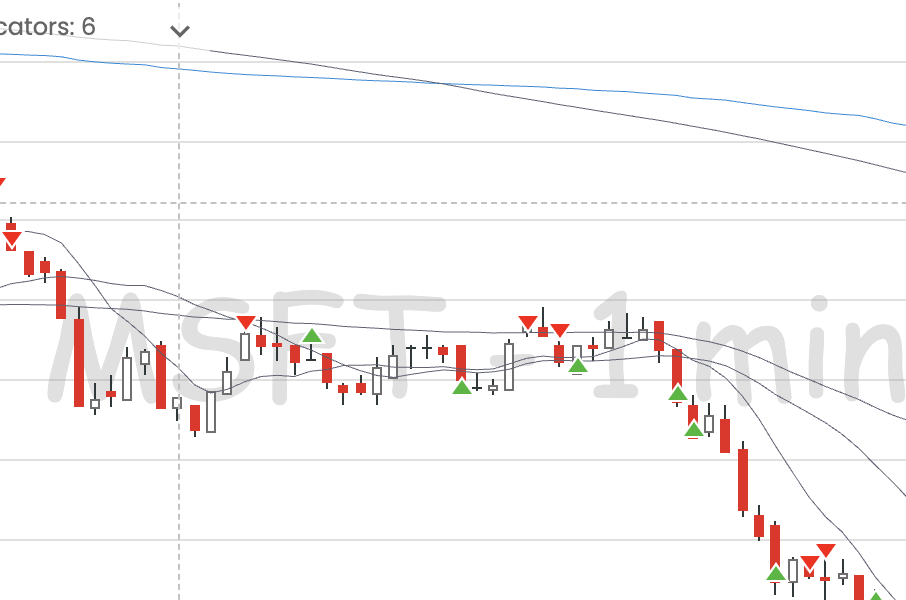

### Correlated stocks at different resistances

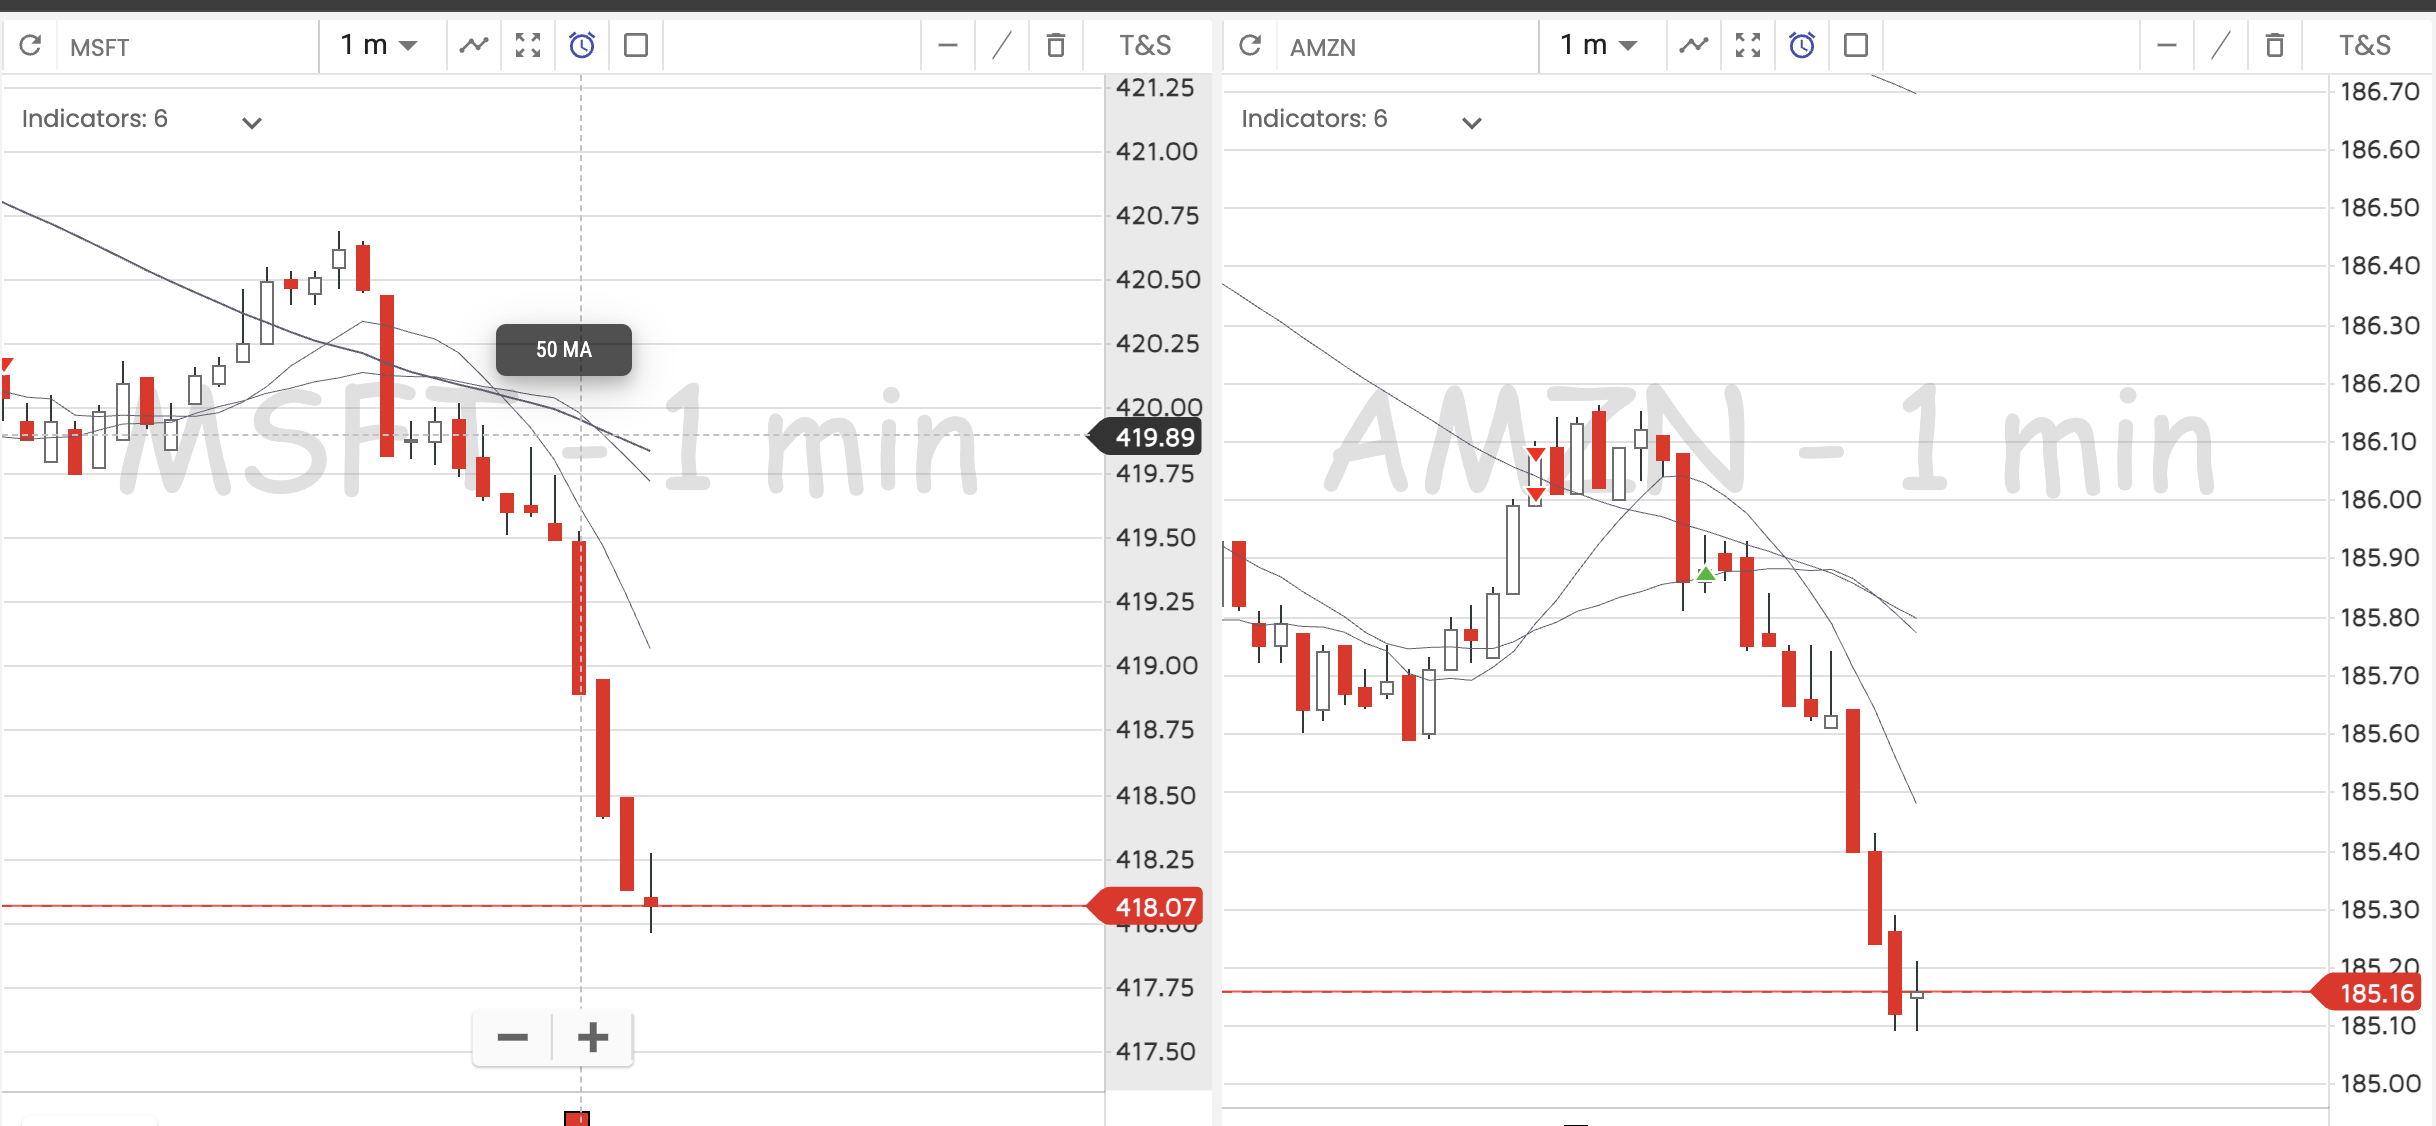